In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

%matplotlib inline

In [ ]:
!git clone https://github.com/benckx/dnn-movie-posters.git
!cd dnn-movie-posters && python3 ./get_data.py -download

# val_files = os.listdir(data_path + '100/')[-100:]
# os.makedirs(val_data_path, exist_ok=True)
# os.makedirs(val_data_path + '100/', exist_ok=True)
# for file in val_files:
#     os.rename(data_path + '100/' + file, val_data_path + '100/'+ file)

In [47]:
from torchvision import datasets, transforms

class ThresholdTransform(object):
  def __init__(self, thr_255):
    self.thr = thr_255  # input threshold for [0..255] gray level, convert to [0..1]

  def __call__(self, x):
    return (x > self.thr).to(x.dtype)


transform=transforms.Compose([
        transforms.ToTensor(),
        ThresholdTransform(0.4)
        ])
dataset = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
val_dataset = datasets.MNIST('../data', train=False, download=True,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 128)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 128)

In [12]:
# batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_buckets = 10

original_shape = [28, 28]
resize_n = 3

In [ ]:
# def bucketize(x):
#     # B C W H
#     #return (x / 25.5).int()
#     return (torch.min(x, torch.tensor(0.99)) * 10).int()

In [ ]:
# import torchvision
# from torchvision import datasets, models, transforms
# from pathlib import Path
# from PIL import Image

# class Posters:
#     def __init__(self, files):
#         self.files = files

#     def __len__(self):
#         return len(self.files)

#     def __getitem__(self, index):
#         poster_transforms = transforms.Compose([
#           transforms.Resize((original_shape[0] // resize_n, original_shape[1] // resize_n)),
#           transforms.ToTensor(), # PIL Image -> Tensor
#           transforms.Lambda(lambda x: bucketize(x)),
#           ])
#         x = Image.open(self.files[index]).convert('L')
#         x = poster_transforms(x)
#         return x

# data_path = "/content/dnn-movie-posters/data/images/100"
# folder_path = Path(data_path)
# train_files = list(folder_path.rglob('*.jpg'))

# train_dataset = Posters(train_files)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                            batch_size=batch_size,
#                                            shuffle=True,
#                                            drop_last=True)


In [13]:
def plot_image(image, cmap=None):
    plt.figure(figsize=(4, 4))
    plt.imshow(image.detach().cpu().permute(1, 2, 0).squeeze(), cmap=cmap)
    plt.show()

In [14]:
import math

def make_mask(include_center, height, width):
    mask = torch.zeros(height, width).long()
    mask[0: int(height / 2)] = 1
    mask[math.floor(height / 2), 0: math.floor(width / 2)] = 1
    if include_center == True:
      mask[math.floor(height / 2), math.floor(width / 2)] = 1
    return mask

In [15]:
class MaskedCNN(nn.Conv2d):
    def __init__(self, include_center, *args, **kwargs):
        super(MaskedCNN, self).__init__(*args, **kwargs)
        self.include_center = include_center
        #Регистрация атрибута, который будет перемещаться вместе с моделью, но не обновляется во время обратного прохода
        self.register_buffer('mask', self.weight.data.clone())

        _, depth, height, width = self.weight.size()
        self.mask.fill_(0)
        self.mask[:,:] = make_mask(self.include_center, height, width)

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedCNN, self).forward(x)

In [16]:
import torch.nn as nn
class PixelCNN(nn.Module):
    def __init__(self, input_channels=1, num_pixels=2):
        super(PixelCNN, self).__init__()

        self.MaskA = nn.Sequential(
            MaskedCNN(False, in_channels = input_channels, out_channels = 128, kernel_size = (7,7), padding = 'same'),
            nn.ReLU())

        self.res1 = nn.Sequential(
            MaskedCNN(True, in_channels = 128, out_channels = 64, kernel_size = (1,1), padding = 'same'),
            nn.ReLU(),
            MaskedCNN(True, in_channels = 64, out_channels = 64, kernel_size = (3,3), padding = 'same'),
            nn.ReLU(),
            MaskedCNN(True, in_channels = 64, out_channels = 128, kernel_size = (1,1), padding = 'same'),
            nn.ReLU(),
        )
        self.res2 = nn.Sequential(
            MaskedCNN(True, in_channels = 128, out_channels = 64, kernel_size = (1,1), padding = 'same'),
            nn.ReLU(),
            MaskedCNN(True, in_channels = 64, out_channels = 64, kernel_size = (3,3), padding = 'same'),
            nn.ReLU(),
            MaskedCNN(True, in_channels = 64, out_channels = 128, kernel_size = (1,1), padding = 'same'),
            nn.ReLU(),
        )

        self.res3 = nn.Sequential(
            MaskedCNN(True, in_channels = 128, out_channels = 64, kernel_size = (1,1), padding = 'same'),
            nn.ReLU(),
            MaskedCNN(True, in_channels = 64, out_channels = 64, kernel_size = (3,3), padding = 'same'),
            nn.ReLU(),
            MaskedCNN(True, in_channels = 64, out_channels = 128, kernel_size = (1,1), padding = 'same'),
            nn.ReLU(),
        )

        self.res4 = nn.Sequential(
            MaskedCNN(True, in_channels = 128, out_channels = 64, kernel_size = (1,1), padding = 'same'),
            nn.ReLU(),
            MaskedCNN(True, in_channels = 64, out_channels = 64, kernel_size = (3,3), padding = 'same'),
            nn.ReLU(),
            MaskedCNN(True, in_channels = 64, out_channels = 128, kernel_size = (1,1), padding = 'same'),
            nn.ReLU(),
        )

        self.res5 = nn.Sequential(
            MaskedCNN(True, in_channels = 128, out_channels = 64, kernel_size = (1,1), padding = 'same'),
            nn.ReLU(),
            MaskedCNN(True, in_channels = 64, out_channels = 64, kernel_size = (3,3), padding = 'same'),
            nn.ReLU(),
            MaskedCNN(True, in_channels = 64, out_channels = 128, kernel_size = (1,1), padding = 'same'),
            nn.ReLU(),
        )

        self.res6 = nn.Sequential(
            MaskedCNN(True, in_channels = 128, out_channels = 64, kernel_size = (1,1), padding = 'same'),
            nn.ReLU(),
            MaskedCNN(True, in_channels = 64, out_channels = 64, kernel_size = (3,3), padding = 'same'),
            nn.ReLU(),
            MaskedCNN(True, in_channels = 64, out_channels = 128, kernel_size = (1,1), padding = 'same'),
            nn.ReLU(),
        )

        self.res7 = nn.Sequential(
            MaskedCNN(True, in_channels = 128, out_channels = 64, kernel_size = (1,1), padding = 'same'),
            nn.ReLU(),
            MaskedCNN(True, in_channels = 64, out_channels = 64, kernel_size = (3,3), padding = 'same'),
            nn.ReLU(),
            MaskedCNN(True, in_channels = 64, out_channels = 128, kernel_size = (1,1), padding = 'same'),
            nn.ReLU(),
        )

        self.final = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = (3,3), padding = 'same'),
            nn.ReLU()
        )

        self.output = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = num_pixels, kernel_size = (3,3), padding = 'same'),
            #nn.Softmax(dim = 1)
            #nn.Sigmoid()
        )

    def forward(self, x):
        x = x.float()
        x = self.MaskA(x)
        x = x.clone() + self.res1(x)
        x = x.clone() + self.res2(x)
        x = x.clone() + self.res3(x)
        x = x.clone() + self.res4(x)
        x = x.clone() + self.res5(x)
        x = x.clone() + self.res6(x)
        x = x.clone() + self.res7(x)
        x = self.final(x)
        x = self.output(x)
        return x

    def generate_samples(self, starting_image, starting_point=(0, 0)):
      height, width = starting_image.shape[-2:]
      if starting_image.ndim == 2:
        starting_image = starting_image.reshape(1, 1, *starting_image.shape)
      elif starting_image.ndim == 3:
        starting_image = starting_image.reshape(1,*starting_image.shape)
      self.eval()
      with torch.no_grad():
        for i in range(starting_point[0],height):
          for j in range(starting_point[1],width):
              probs = self(starting_image)[starting_point][..., starting_point[0], starting_point[1]]
              point = torch.multinomial(probs, 1, replacement = True)
              starting_image[starting_point][..., starting_point[0], starting_point[1]] = point

      return starting_image


In [17]:
def plot_losses(losses):
    plt.figure(figsize=(4, 4))
    plt.plot(losses)
    plt.show()

In [67]:
model = PixelCNN(num_pixels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
criterion = nn.CrossEntropyLoss()

  0%|          | 0/469 [00:00<?, ?it/s]

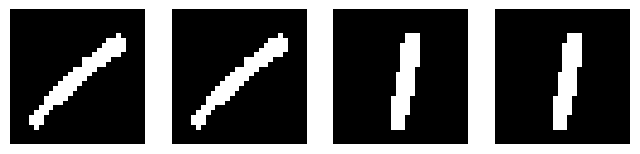

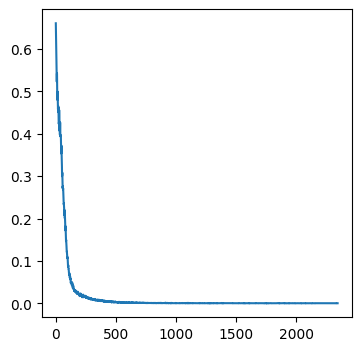

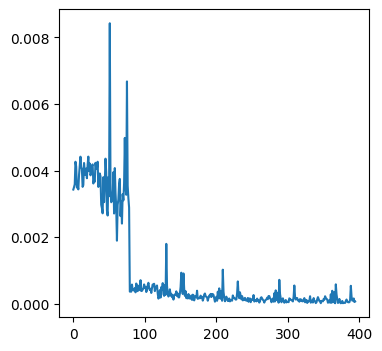

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
losses = []
val_losses = []
starting_x, starting_y = 0, 0

for i in tqdm(range(10)):
    model.train()
    for ind, (image, label) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        optimizer.zero_grad()
        image = image.to(device)
        logits = model(image)
        loss = criterion(logits, image.long().squeeze())
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

    clear_output()
    j = torch.randint(0,96,(1,))
    plt.figure(figsize = (8,4))
    plt.subplot(1,4,1)
    plt.imshow(image[j[0]].detach().cpu().permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.imshow(torch.max(logits, dim = 1)[1][j[0]][None,:].detach().cpu().permute(1, 2, 0).squeeze(), cmap = 'gray')
    plt.axis('off')


    with torch.no_grad():
      model.eval()
      for ind, (image, label) in tqdm(enumerate(val_loader), total=len(train_loader), leave=False):
        image = image.to(device)
        logits = model(image)
        loss = criterion(logits, image.long().squeeze())
        val_losses.append(loss.item())

      j = torch.randint(0,16,(1,))
      plt.subplot(1,4,3)
      plt.imshow(image[j[0]].detach().cpu().permute(1, 2, 0).squeeze(), cmap='gray')
      plt.axis('off')

      plt.subplot(1,4,4)
      plt.imshow(torch.max(logits, dim = 1)[1][j[0]][None,:].detach().cpu().permute(1, 2, 0).squeeze(), cmap = 'gray')
      plt.axis('off')

    # model.eval()
    # image, _ = next(iter(val_loader))
    # starting_image = image.clone()
    # starting_image[:, :, starting_x:, starting_y:] = 0
    # sample = model.generate_samples(starting_image[:2].to(device), (starting_x, starting_y))
    # plot_image(sample[0])
    plot_losses(losses)
    plot_losses(val_losses)

In [ ]:
def generate_samples(model, starting_image, starting_point=(0, 0)):
      height, width = starting_image.shape[-2:]
      if starting_image.ndim == 2:
        starting_image = starting_image.reshape(1, 1, *starting_image.shape)
      elif starting_image.ndim == 3:
        starting_image = starting_image.reshape(1,*starting_image.shape)
      model.eval()
      softmax = nn.Softmax(dim = 1)
      with torch.no_grad():
        for i in range(starting_point[0],height):
          for j in range(starting_point[1],width):
              probs = softmax(model(starting_image))[..., i, j]
              point = torch.multinomial(probs, 1, replacement = True)
              starting_image[..., i, j] = point
      return starting_image


In [ ]:
sample = torch.zeros(2,1,28,28).to(device)
res = generate_samples(model, sample, starting_point=(0,0))
plt.imshow(res[0].detach().cpu().permute(1, 2, 0).squeeze(), cmap='gray')

In [ ]:
res[0]

In [ ]:

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from packaging.version import parse as parse_version

In [ ]:
(ds_train, ds_test), ds_info = tfds.load('mnist',
                              split=['test', 'test'],
                              shuffle_files=True,
                              as_supervised=True,
                              with_info=True)

#fig = tfds.show_examples(ds_info, ds_train)

def binarize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.math.round(image/255.)
    return image, tf.cast(image, tf.int32)

ds_train = ds_train.map(binarize)
ds_train = ds_train.cache() # put dataset into memory
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(64)
ds_test = ds_test.map(binarize).batch(64).cache().prefetch(64)

In [ ]:
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, kernel=5, filters=1):
        super(MaskedConv2D, self).__init__()
        self.kernel = kernel
        self.filters = filters
        self.mask_type = mask_type

    def build(self, input_shape):

        self.w = self.add_weight(shape=[self.kernel,
                                        self.kernel,
                                        input_shape[-1],
                                        self.filters],
                                initializer='glorot_normal',
                                trainable=True)

        self.b = self.add_weight(shape=(self.filters,),
                                initializer='zeros',
                                trainable=True)
        # Create Mask
        mask = np.ones(self.kernel**2, dtype=np.float32)
        center = len(mask)//2
        mask[center+1:] = 0
        if self.mask_type == 'A':
            mask[center] = 0

        mask = mask.reshape((self.kernel, self.kernel, 1, 1))

        self.mask = tf.constant(mask, dtype='float32')

    def call(self, inputs):
        # mask the convolution
        masked_w = tf.math.multiply(self.w, self.mask)

        # perform conv2d using low level API
        output = tf.nn.conv2d(inputs, masked_w, 1, "SAME") + self.b

        return tf.nn.relu(output)

class ResidualBlock(layers.Layer):
    def __init__(self, h=32):
        super(ResidualBlock, self).__init__()

        self.forward = Sequential([MaskedConv2D('B', kernel=1, filters=h),
                                   MaskedConv2D('B', kernel=3, filters=h),
                                   MaskedConv2D('B', kernel=1, filters=2*h)])
    def call(self, inputs):
        x = self.forward(inputs)
        return x + inputs

def SimplePixelCnn(hidden_features=64,
                   output_features=64,
                   resblocks_num=7):

    inputs  = layers.Input(shape=[28,28,1])
    x = inputs

    x = MaskedConv2D('A',kernel=7, filters=2*hidden_features)(x)

    for _ in range(resblocks_num):
        x = ResidualBlock(hidden_features)(x)

    x = layers.Conv2D(output_features, (1,1), padding='same', activation='relu')(x)
    x = layers.Conv2D(1, (1,1), padding='same', activation='sigmoid')(x)

    return tf.keras.Model(inputs=inputs, outputs=x, name='PixelCnn')

pixel_cnn = SimplePixelCnn()
pixel_cnn.summary()

In [ ]:
pixel_cnn.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=[tf.keras.losses.BinaryCrossentropy()])

pixel_cnn.fit(ds_train, epochs = 5, validation_data=ds_test)

In [ ]:
grid_row = 5
grid_col = 5
batch = grid_row * grid_col
h = w = 28
images = np.zeros((batch,h,w,1), dtype=np.float32)

for row in range(h):

    for col in range(w):

        prob = pixel_cnn.predict(images)[:,row,col,0]

        pixel_samples = tf.random.categorical(tf.math.log(np.stack([1-prob, prob],1)), 1)

        images[:,row,col,0] = tf.reshape(pixel_samples,[batch])

In [ ]:
# Display
f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.1,grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)
plt.show()